In [42]:
import numpy as np
import scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

We want to try our SVM on a small/easy toy data set and therefore create 50 linearly seperable data points  in $\mathbb{R}^2$.

In [43]:
def initialize(l,n):
    data = 2*np.random.rand(l,n)-1  #create l random data points uniformly distributed over [-1,1]^n
    rand_direction = np.random.rand(n)-0.5 #direction of seperating hyperplane
    rand_transition = 0.2*np.random.random() #transition of seperating hyperplane
    labels = np.array([np.dot(i,rand_direction) > rand_transition for i in data])
    return data, labels, rand_direction, rand_transition

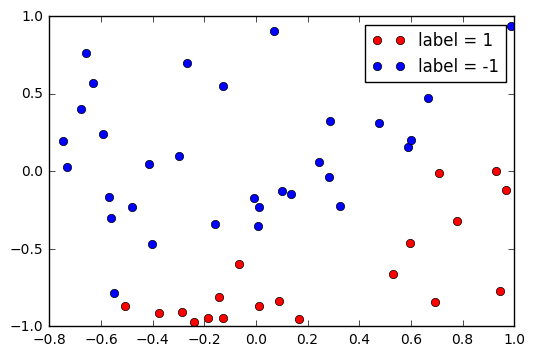

In [44]:
# fix random seed for reproducibility
seed = 2
np.random.seed(seed)
example_data, example_labels, example_rand_direction, example_rand_transition = initialize(50, 2)
example_data, example_labels, example_rand_direction, example_rand_transition
label1 = example_data[example_labels]
label0 = np.array(example_data[~example_labels])

#replace 0-labels with -1
example_labels = np.array([1 if x == True else -1 for x in example_labels])
fig1 = plt.figure()
p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
legend = plt.legend(handles = [p1, p2])

## Linear Kernel using sklearn's SVC

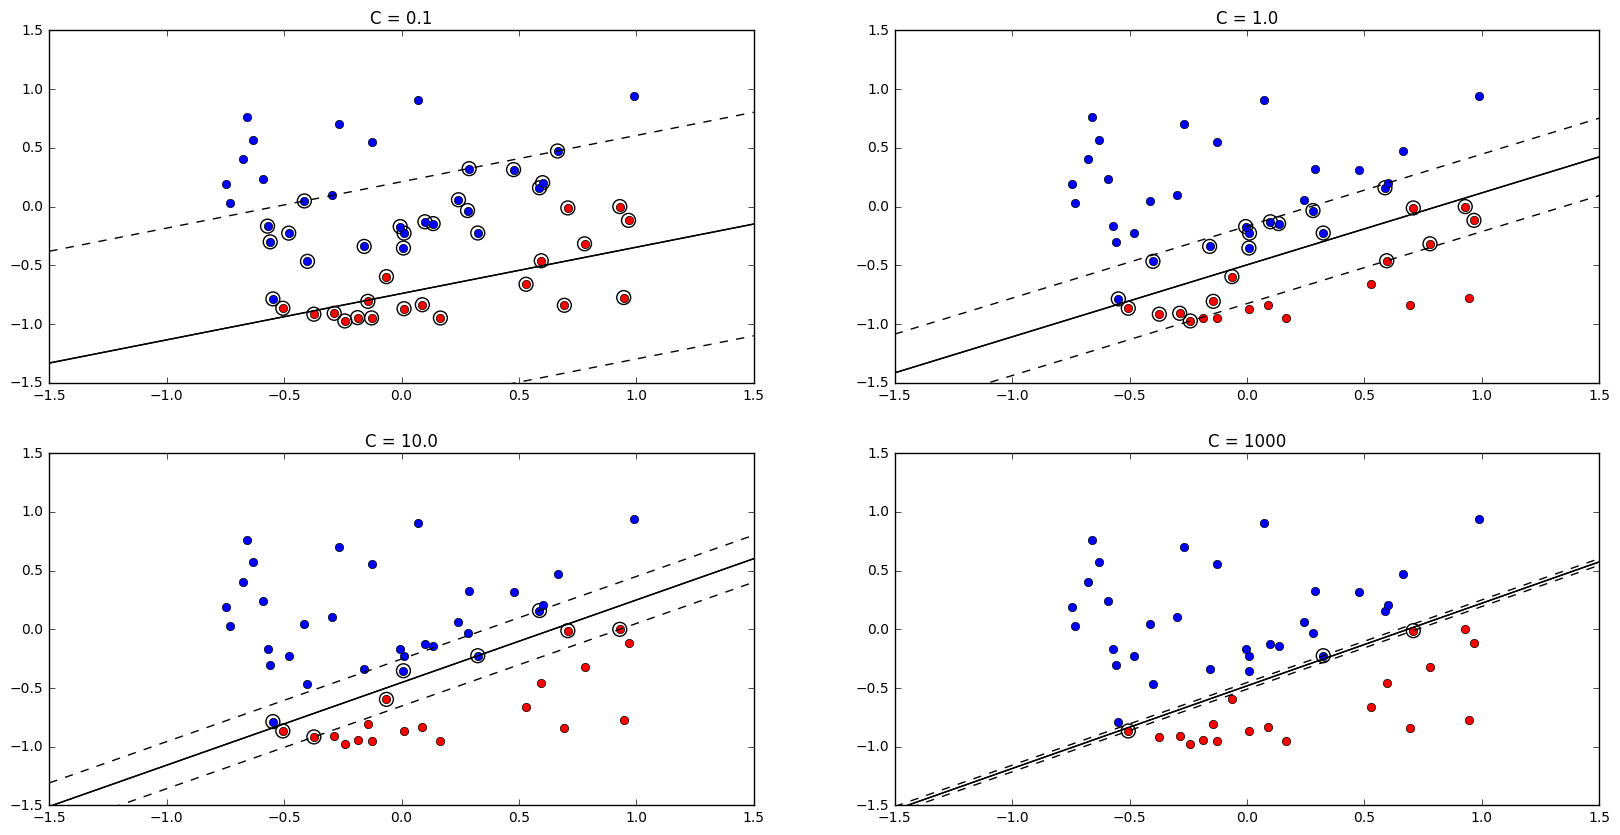

In [80]:
#get seperating hyperplane
C_list = [0.1, 1., 10., 1000]
plt_list = []
fig_linear = plt.figure(figsize=(20,10))

for i in range(4):
    C = C_list[i]
    my_svm = SVC(C=C, kernel='linear')
    my_svm.fit(example_data, example_labels)
    w = my_svm.coef_[0]
    m = -w[0] / w[1]   #slope of equation that describes the decision boundary
    x = np.linspace(-1.5, 1.5)
    b = my_svm.intercept_[0]   #transition of hyperplane
    y = m * x - b / w[1]

    plt_list.append(fig_linear.add_subplot(221+i))
    plt_list[i].plot(x, y, 'k-')
    p1, = plt_list[i].plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
    p2, = plt_list[i].plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')

    #get margin
    margin = 1 / np.linalg.norm(w)
    lower_margin = y + np.sqrt(m**2+1)* margin
    upper_margin = y - np.sqrt(m**2+1) * margin
    plt.plot(x, y, 'k-', x, lower_margin, 'k--', x,upper_margin, 'k--')

    #get support vectors
    supp_vectors = my_svm.support_vectors_
    plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')

    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('C = '+str(C))

Beobachtung: Großes C führt zu schmaler Margin mit wenigen Support Vektoren aber ggf Overfitting, da Trainingsdaten innerhalb der Margin hart bestraft werden.

## Gauss Kernel using sklearn's SVC

In [76]:
def gaussian_kernel(x, y, sigma):
    return np.exp(-sigma*np.linalg.norm(x-y)**2)

def decision_function(x, supp_vectors, atimeslabels_supp,b, gamma): #nur fuer Gauss-Kernel
    k = np.array([gaussian_kernel(y, x, gamma) for y in supp_vectors])
    return np.dot(atimeslabels_supp, k) + b

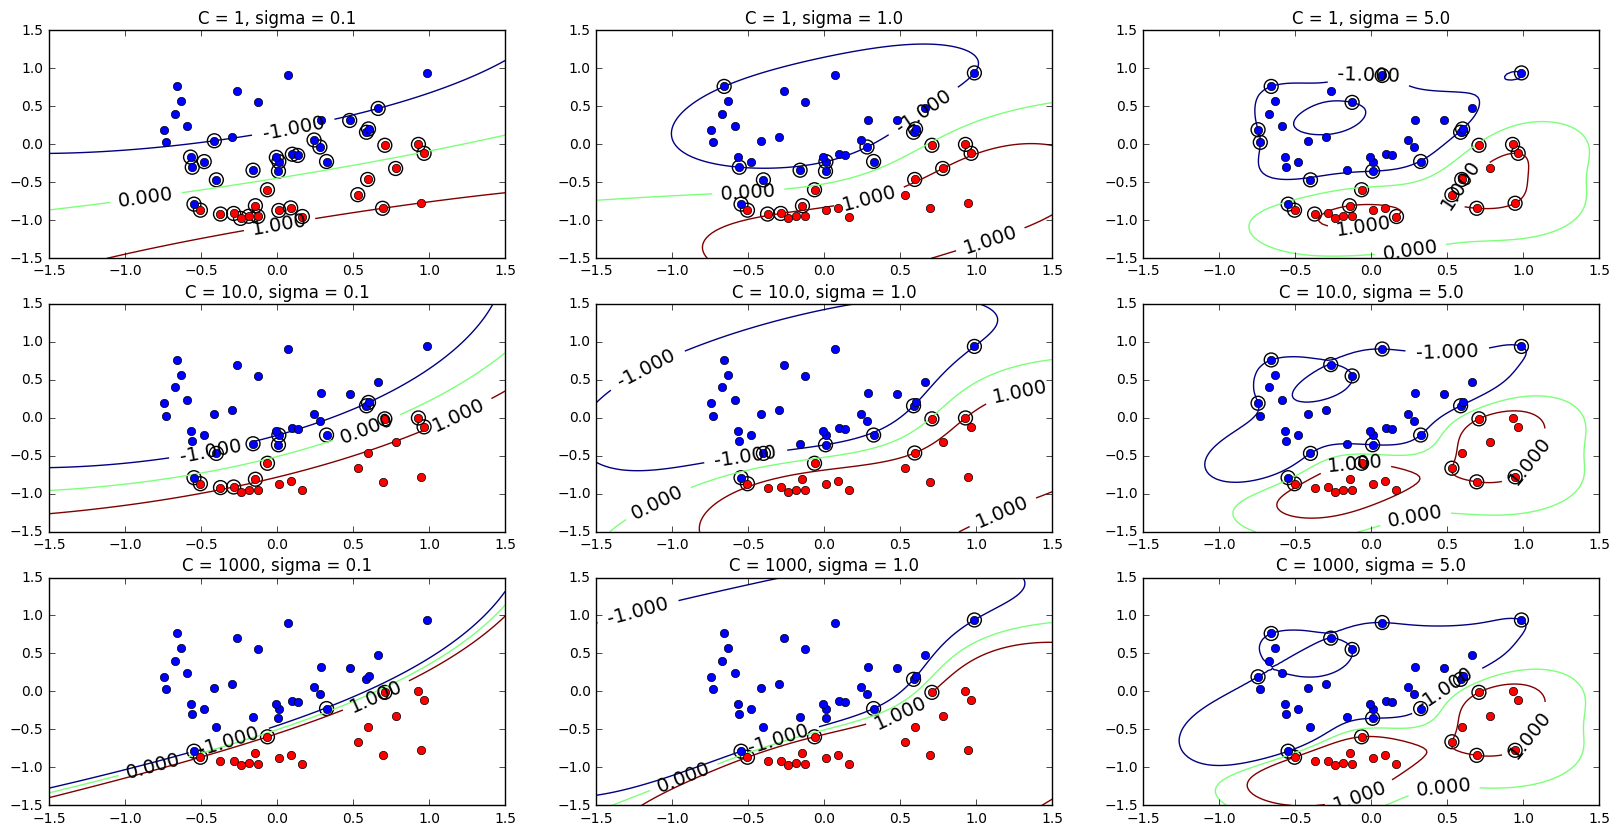

In [77]:
C_list = [1, 10., 1000]
gamma_list = [0.1, 1., 5.]
plt_list = []
fig_gauss = plt.figure(figsize=(20,10))

for i in range(len(C_list)):
    C = C_list[i]
    plt_list.append([])
    for j in range(len(gamma_list)):
        gamma = gamma_list[j]
        my_svm = SVC(C=C, kernel='rbf', gamma=gamma)
        my_svm.fit(example_data, example_labels);
        #get decision function
        atimeslabels = my_svm.dual_coef_
        b = my_svm.intercept_[0]   #transition of hyperplane
        supp_vectors = my_svm.support_vectors_
        supp_indices = my_svm.support_   #indices of support vectors
        
        x = np.linspace(-1.5, 1.5, 100)
        X, Y = np.meshgrid(x, x)
        Z = np.array([[decision_function(np.array([x1, x2]), supp_vectors, atimeslabels,b, gamma) for x1 in x] for x2 in x])
        Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
        
        plt_list[i].append(fig_gauss.add_subplot(331+3*i+j))        
        CS = plt_list[i][j].contour(X, Y, Z, levels = [-1, 0, 1])
        plt.clabel(CS, colors = 'k', fontsize=14)

        p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
        p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
        plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.title('C = '+str(C) + ', sigma = ' + str(gamma))


Beobachtung: großes $\sigma$ führt zu Overfitting. Großes $C$ führt zu einer schmalen Margin mit wenigen Support Vektoren.

## Now using Paul's SMO
### Linear Kernel

In [48]:
from smo import smo

In [49]:
def scalar_product(v1,v2):
    '''standard scalar product'''
    return np.dot(v1,v2)

In [59]:
def extract_suppvectors(alpha, data):
    supp_indices = np.array([i for i in range(len(data)) if not alpha[i]==0])
    supp_vectors = data[supp_indices]
    return supp_indices, supp_vectors

def extract_w(alpa, labels, data):
    #nur für linear kernels
    w = np.sum((np.array(alpha[i]*labels[i]*data[i]) for i in supp_indices), axis = 0)
    return w

def y_withoutb(x, alpha_supp, labels_supp, data_supp, kernel):
    alphatimeslabels = np.multiply(alpha_supp, labels_supp)
    k = np.array([kernel(x, y) for y in data_supp])
    return np.dot(alphatimeslabels, k)

def extract_b(alpha_supp, labels_supp, data_supp, kernel, C):
    indicesonmargin = np.array([i for i in range(len(data_supp)) if alpha_supp[i]<C ])
    return 1./len(indicesonmargin)*sum([labels_supp[i]-y_withoutb(data_supp[i],alpha_supp, labels_supp, data_supp, kernel) for i in indicesonmargin])

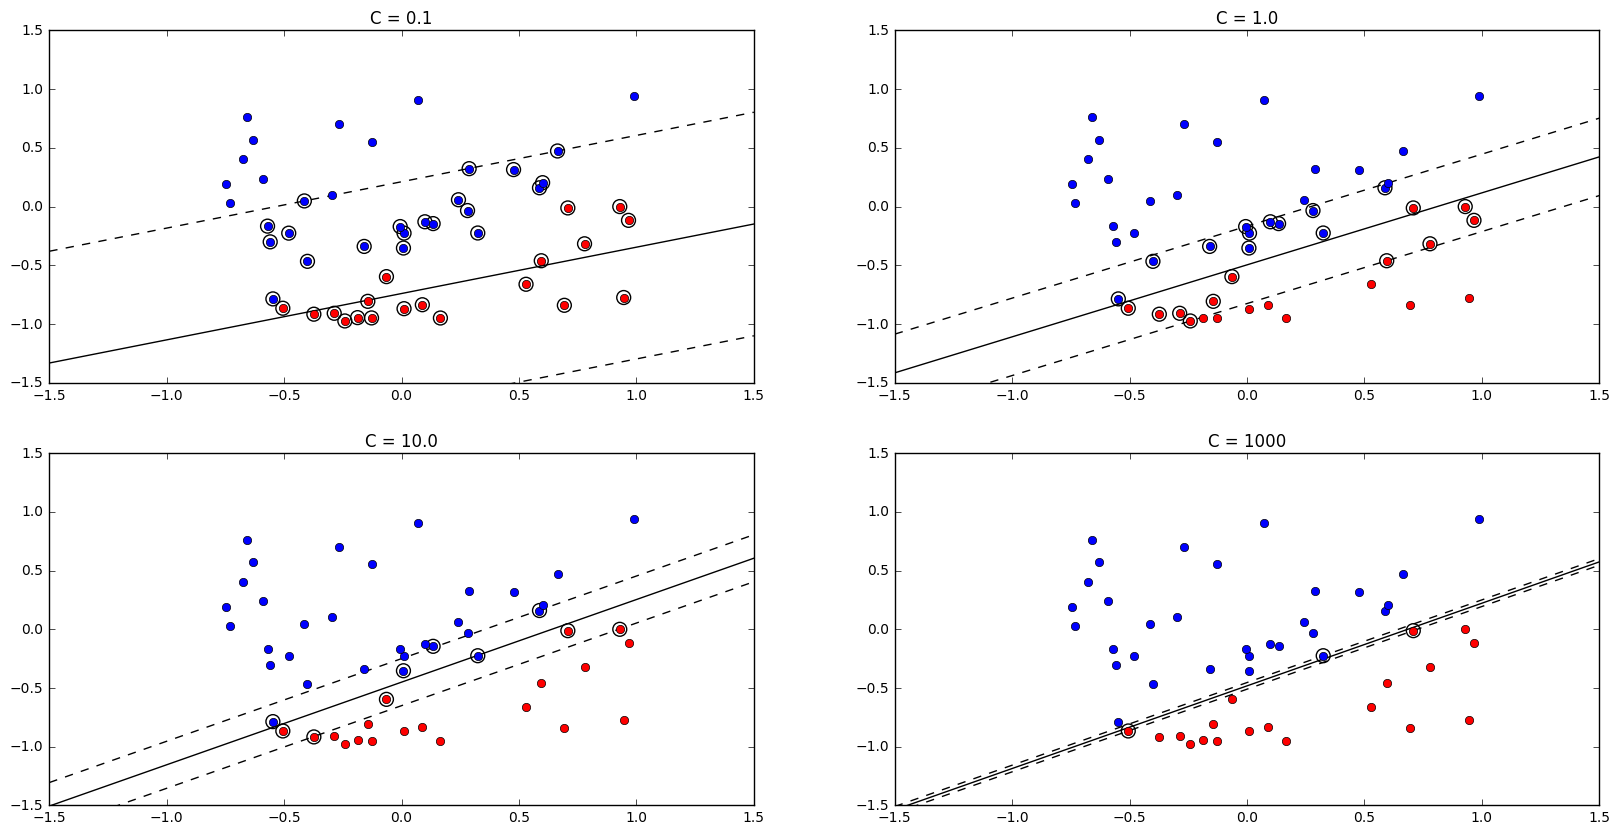

In [81]:
C_list = [0.1, 1., 10., 1000]
plt_list = []
fig_linear_Paul = plt.figure(figsize=(20,10))
x = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(x, x)

for i in range(4):
    C = C_list[i]
    solution = smo(np.transpose(example_data),example_labels,C,scalar_product,1e-5,'yes', kernel_identifier='standard scalar product')
    alpha = solution['solution']
    supp_indices, supp_vectors = extract_suppvectors(alpha, example_data)
    w = extract_w(alpha, example_labels, example_data)
    b = extract_b(alpha[supp_indices], example_labels[supp_indices], supp_vectors, scalar_product, C)
    m = -w[0] / w[1]   #Steigung der Funktionsgleichung, die die decision boundary beschreibt
    x = np.linspace(-1.5, 1.5)
    y = m * x - b / w[1]
    
    #get margin
    margin = 1 / np.linalg.norm(w)
    lower_margin = y + np.sqrt(m**2+1)* margin
    upper_margin = y - np.sqrt(m**2+1) * margin
    
    plt_list.append(fig_linear_Paul.add_subplot(221+i))
    plt_list[i].plot(x, y, 'k-', x, lower_margin, 'k--', x,upper_margin, 'k--')
    p1, = plt_list[i].plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
    p2, = plt_list[i].plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
    plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title('C = '+str(C))
    
#plt.savefig('Plots_linear_mit_Pauls_SVM.pdf')

### Gauss Kernel

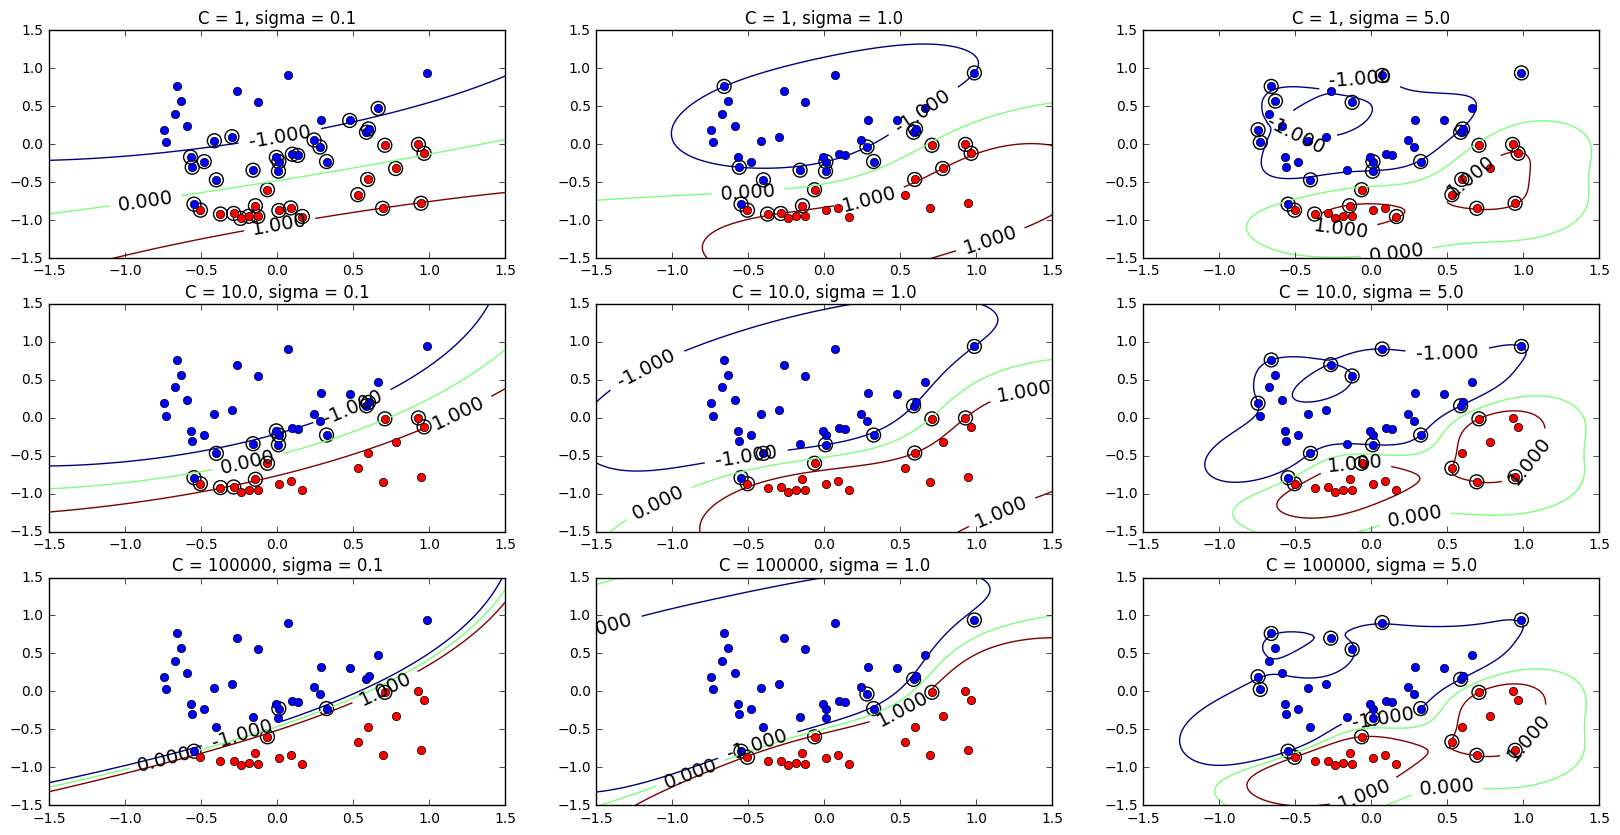

In [82]:
C_list = [1, 10., 100000]
gamma_list = [0.1, 1., 5.]
plt_list = []
fig_gauss_Paul = plt.figure(figsize=(20,10))
x = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(x, x)

for i in range(len(C_list)):
    C = C_list[i]
    plt_list.append([])
    for j in range(len(gamma_list)):
        gamma = gamma_list[j]
        def kernel(x,y):
            return gaussian_kernel(x,y,gamma)
        
        solution = smo(np.transpose(example_data),example_labels,C,kernel,1e-5,'yes')
        alpha = solution['solution']
        
        #get decision function
        supp_indices, supp_vectors = extract_suppvectors(alpha, example_data) #support vectors and indices of support vectors
        atimeslabels_supp = np.multiply(alpha[supp_indices], example_labels[supp_indices])
        b = extract_b(alpha[supp_indices], example_labels[supp_indices], example_data[supp_indices], kernel, C)
        
        Z = np.array([[decision_function(np.array([xi, xj]), supp_vectors, atimeslabels_supp,b, gamma) for xi in x] for xj in x])
        Z = np.reshape(Z, (np.shape(Z)[0], np.shape(Z)[1]))
        
        plt_list[i].append(fig_gauss_Paul.add_subplot(331+3*i+j))        
        CS = plt_list[i][j].contour(X, Y, Z, levels = [-1, 0, 1])
        plt.clabel(CS, colors = 'k', fontsize=14)

        p1, = plt.plot(label1[:,0], label1[:,1], 'ro', label = 'label = 1')
        p2, = plt.plot( label0[:,0], label0[:,1], 'o', label = 'label = -1')
        plt.scatter(supp_vectors[:,0], supp_vectors[:,1], s=100, facecolors = 'none')
        plt.xlim([-1.5, 1.5])
        plt.ylim([-1.5, 1.5])
        plt.title('C = '+str(C) + ', sigma = ' + str(gamma))
#plt.savefig('Plots_Gauss_mit_Pauls_SVM.pdf')